In [1]:
# Script to compare photo-z performance in redmapper clusters

import jplus
import numpy as np
from astropy.io import fits

redmap_dir = '/home/CEFCA/aaorsi/work/redmapper/'
redmap_cat = '%sredmapper_dr8_public_v6.3_catalog.fits' % redmap_dir
redmap_mem = '%sredmapper_dr8_public_v6.3_members.fits' % redmap_dir

# loading J-PLUS catalogue
mag_type = 'gpsfMags' 
gal_jplus0 = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=1, mag_limit=[16,21.],
                                                extra_where_conds='',db='dr1', allphotoz=True)


print 'J-PLUS catalogue loaded'

        






j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_dr1_dual_magmax21.0.h5


J-PLUS catalogue loaded


In [2]:
# Load and prepare redmapper catalogue

fc = fits.open(redmap_cat)
rm_cat = fc[1].data

fm = fits.open(redmap_mem)
rm_mem = fm[1].data

print 'Redmapper data loaded'

mem_sel = rm_mem['p'] > 0.9 # Membership probability higher than 90%
nmem = len(np.where(mem_sel)[0])
print 'Number of RedMapper galaxies to cross-match with J-PLUS:%ld' %nmem

#rm_coords = [[rm_mem['RA'][mem_sel][i], rm_mem['DEC'][mem_sel][i]] for i in range(nmem)]
rm_ids = rm_mem['ID'][mem_sel]
rm_ra = rm_mem['RA'][mem_sel]
rm_dec = rm_mem['DEC'][mem_sel]


rm_zrm  = np.zeros(nmem)
rm_coords = np.zeros([nmem,2])
print 'Getting redshifts and coordinates from redmapper members'
for i in range(nmem):
    idz = np.where(rm_cat['ID'] == rm_ids[i])
    rm_zrm[i] = rm_cat['Z_LAMBDA'][idz] # The redshift of the cluster for each member
    rm_coords[i,:] = [rm_ra[i], rm_dec[i]]
    if i%10000 == 0:
        print i



Redmapper data loaded
Number of RedMapper galaxies to cross-match with J-PLUS:242814
Getting redshifts and coordinates from redmapper members
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


In [3]:
# Performing Cross-match

print 'Cross-match of Redmappper cluster members with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(gal_jplus0['coords'],rm_coords,max_distance=3e-4)
m = ((d != np.inf))
    
jrm = jplus.tools.select_object(gal_jplus0, m)
memj = ind[m]
jrm['z_redmapper'] = rm_zrm[ind[m]]
print jrm['z_redmapper']
print d, ind

print rm_coords


print 'done. %ld galaxies in J-PLUS and RedMapper'%len(jrm['tile_id'])

Cross-match of Redmappper cluster members with J-PLUS ...
[ 0.46093255  0.50774974  0.31770784 ...,  0.30419573  0.30419573
  0.13619062]
[ inf  inf  inf ...,  inf  inf  inf] [242814 242814 242814 ..., 242814 242814 242814]
[[ 239.85233435   27.21684991]
 [ 239.81196798   27.17299655]
 [ 239.83922287   27.19653776]
 ..., 
 [ 153.81808387   43.62878777]
 [ 135.95009864   15.20462004]
 [ 135.96337099   15.20173173]]
done. 6291 galaxies in J-PLUS and RedMapper


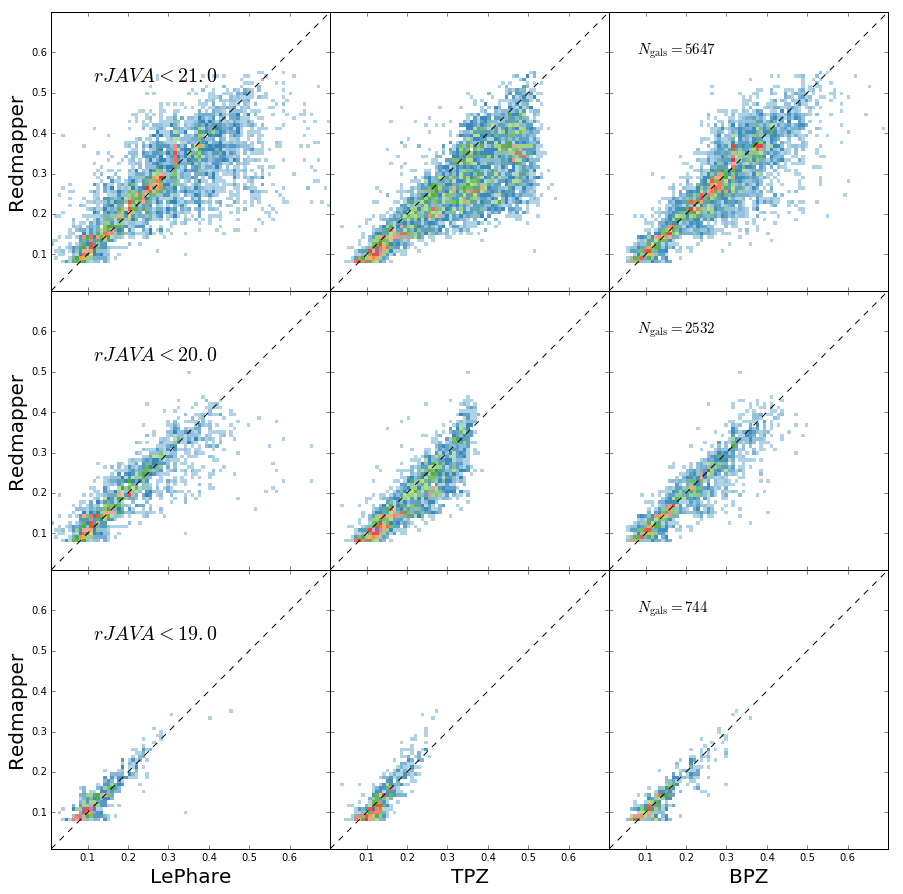

"\nplt.hist(gal_jplus0['photoz_leph'],bins=20,alpha=0.5,label='Lephare')\nplt.hist(gal_jplus0['photoz_bpz'],bins=20,alpha=0.5,label='BPZ')\nplt.hist(gal_jplus0['photoz_tpz'],bins=20,alpha=0.5,label='TPZ')\nplt.legend()\nplt.show()\n"

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm

plt.rcParams['figure.figsize'] = 15, 15

plt.figure('Photoz_validation')
   
gs = gsc.GridSpec(3,3)
gs.update(wspace=0.0, hspace=0.0)

xr = [0.01,0.7]
yr = [0.01,0.7]

samp = jrm # change to jrm eventually

pz_list = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
leg_list = ['LePhare', 'TPZ','BPZ']
rlim = [21, 20, 19]

for j in range(3):
    sel = samp['rJAVA'][:,0] < rlim[j]
    for i in range(3):
        ax = plt.subplot(gs[j,i])
        counts, ybins, xbins, image = ax.hist2d(samp[pz_list[i]][sel], samp['z_redmapper'][sel], bins=80, 
                                             range=[xr, yr],cmap=plt.cm.Paired, normed=LogNorm(), 
                                             cmin=0.01, label=leg_list[i], alpha=0.9)
        ax.plot(xr,yr,'k--')
        ax.set_xlabel(leg_list[i],fontsize=20)
        
        if i == 0:
            ax.set_ylabel('Redmapper',fontsize=20)
            ax.text(0.15,0.75,r'$rJAVA < %.1f$'% rlim[j], fontsize=20,transform=ax.transAxes)
        else:
            ax.set_yticklabels([])
       
        if i == 2:
            ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(samp['z_redmapper'][sel]), fontsize=15,transform=ax.transAxes)

plt.show()







"""
plt.hist(gal_jplus0['photoz_leph'],bins=20,alpha=0.5,label='Lephare')
plt.hist(gal_jplus0['photoz_bpz'],bins=20,alpha=0.5,label='BPZ')
plt.hist(gal_jplus0['photoz_tpz'],bins=20,alpha=0.5,label='TPZ')
plt.legend()
plt.show()
"""

In [5]:

%debug


ERROR:root:No traceback has been produced, nothing to debug.


In [6]:
# Cross-match with ALHAMBRA catalogue

print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(gal_jplus0['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))
jp_alh = jplus.tools.select_object(gal_jplus0, alh_m)


# Cross match with ELG selection.... 
alha_xjp = jplus.tools.select_object(alh, alh_ind[alh_m])
jp_alh['zphoto'] = alha_xjp['zphoto']

print len(jp_alh['zphoto'])


Reading and performing cross-match with ALHAMBRA objects
['F830W', 'F814W', 'F799W', 'F644W', 'F892W', 'F954W', 'F582W', 'zphoto', 'F427W', 'F675W', 'F551W', 'F768W', 'F365W', 'F706W', 'F458W', 'cstar', 'F489W', 'F861W', 'F923W', 'coords', 'F613W', 'F396W', 'F737W', 'F520W']
1799


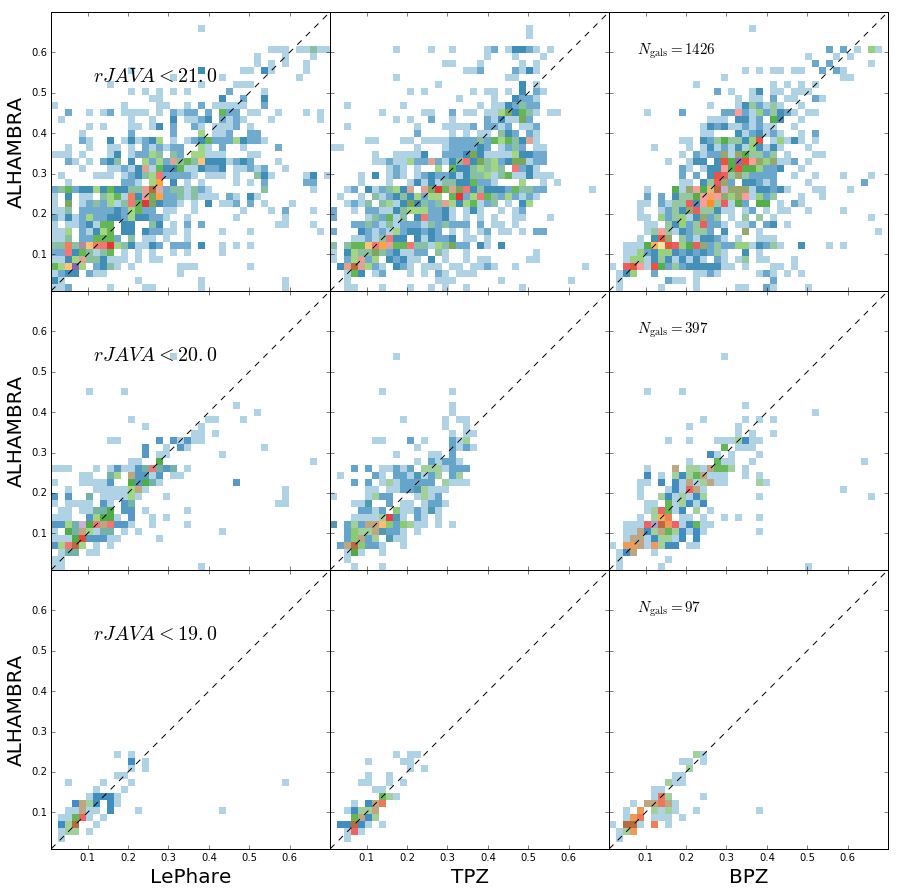

In [52]:
# And plots

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm


plt.rcParams['figure.figsize'] = 15, 15

plt.figure('Photoz_validation_alh')
   
gs = gsc.GridSpec(3,3)
gs.update(wspace=0.0, hspace=0.0)

xr = [0.01,0.7]
yr = [0.01,0.7]

samp = jp_alh # change to jrm eventually

pz_list = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
leg_list = ['LePhare', 'TPZ','BPZ']
rlim = [21, 20, 19]

for j in range(3):
    sel = samp['rJAVA'][:,0] < rlim[j]
    for i in range(3):
        ax = plt.subplot(gs[j,i])
        counts, ybins, xbins, image = ax.hist2d(samp[pz_list[i]][sel], samp['zphoto'][sel], bins=40, 
                                             range=[xr, yr],cmap=plt.cm.Paired, normed=LogNorm(), 
                                             cmin=0.01, label=leg_list[i], alpha=0.9)
        ax.plot(xr,yr,'k--')
        ax.set_xlabel(leg_list[i],fontsize=20)
        
        if i == 0:
            ax.set_ylabel('ALHAMBRA',fontsize=20)
            ax.text(0.15,0.75,r'$rJAVA < %.1f$'% rlim[j], fontsize=20,transform=ax.transAxes)
        else:
            ax.set_yticklabels([])
       
        if i == 2:
            ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(samp['zphoto'][sel]), fontsize=15,transform=ax.transAxes)

plt.show()







AttributeError: 'module' object has no attribute 'photoz_error_hist_b'

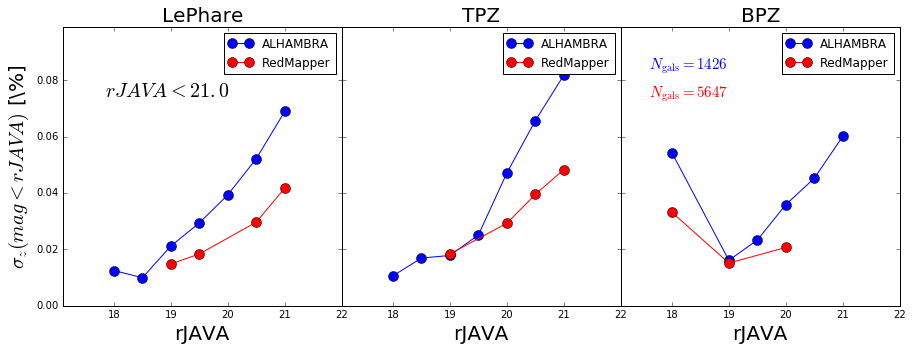

In [44]:
def mag_sigma(gal, photoz, label=None, zspeckey='zphoto', color='red',fontsize=15,mlim=[18,21]):
    mag_limit = np.linspace(mlim[0],mlim[1],7)
    sigma = []
    delta_z  = (gal[zspeckey] - photoz)/(1 + gal[zspeckey])
    for mlim in mag_limit:
        
        hist, bins = np.histogram(delta_z[gal['rJAVA'][:,0] < mlim], bins=np.linspace(-0.2, 0.2, 40))
        bin_centres = (bins[:-1] + bins[1:])/2
        if len(np.where(gal['rJAVA'][:,0] < mlim)[0]) < 3:
            sigma.append(np.nan)
        else:
            xx_fit, yy_fit, coeff, outl_frac = jplus.plotting.compute_sigma(bin_centres, hist, delta_z[gal['rJAVA'][:,0] < mlim])
            sigma.append(coeff[2])
    
    gs = np.asarray(sigma) < 0.1
    plt.plot(mag_limit[gs], np.asarray(sigma)[gs], '-o', label=label, color=color,markersize=10)
    plt.xlim([16.5, 22])
    plt.ylim([0.0, 0.07])
    plt.ylabel("$\sigma_z( mag < rJAVA)$ [\%]",fontsize=fontsize)
    plt.xlabel("rJAVA [mag]")
    plt.legend()

xr = [17.1,22]
yr = [0.,0.099]

samp = jp_alh # change to jrm eventually

pz_list = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
leg_list = ['LePhare', 'TPZ','BPZ']
rlim = [21]


for j in range(1):
    sel_alh = jp_alh['rJAVA'][:,0] < rlim[j]
    sel_rm = jrm['rJAVA'][:,0] < rlim[j]
    for i in range(3):
        ax = plt.subplot(gs[j,i])
        jp_sel = jplus.tools.select_object(jp_alh, sel_alh)
        jp_rm = jplus.tools.select_object(jrm, sel_rm)
        
        mag_sigma(jp_sel, jp_sel[pz_list[i]], zspeckey='zphoto',label='ALHAMBRA', color='blue',mlim=[18.,rlim[j]],fontsize=20)
        mag_sigma(jp_rm, jp_rm[pz_list[i]], zspeckey='z_redmapper',label='RedMapper', color='red',mlim=[18.,rlim[j]],fontsize=20)
        #counts, ybins, xbins, image = ax.hist2d(samp[pz_list[i]][sel], samp['zphoto'][sel], bins=80, 
        #                                     range=[xr, yr],cmap=plt.cm.coolwarm, normed=LogNorm(), 
        #                                     cmin=0.01, label=leg_list[i], alpha=0.9)
        ax.set_xlim(xr)
        ax.set_ylim(yr)
        ax.set_xlabel('rJAVA',fontsize=20)
        
        if j == 0:
            ax.set_title(leg_list[i],fontsize=20)
        if i == 0:
            ax.text(0.15,0.75,r'$rJAVA < %.1f$'% rlim[j], fontsize=20,transform=ax.transAxes)
        else:
            ax.set_yticklabels([])
            ax.set_ylabel('')
       
        if i == 2:
            ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(jp_sel['zphoto']), fontsize=15,transform=ax.transAxes,color='blue')
            ax.text(0.1,0.75,r'$N_{\rm gals}=%ld$'% len(jp_rm['z_redmapper']), fontsize=15,transform=ax.transAxes,color='red')

plt.show()
    
